# Coastal changes with DEP Coastlines

In this lesson, we'll be looking at coastal erosion (retreat) and accretion (growth)
over time in Vanuatu, based on
[DEP's Pacific Coastlines (Beta)](https://github.com/digitalearthpacific/dep-coastlines)
product. This product consists of **annual shorelines** at mean sea level, created by
combining Landsat collection 2 surface reflectance data with tidal modelling
(Bishop-Taylor et al., 2021). It also comes with a **rates of change** point dataset
that provides coastal change statistics at every 30 metres along shorelines.

Links:
- DEP map interface: https://maps.digitalearthpacific.org/#share=s-tIricadkEWrHOQy58RD1
- Data download: https://data.digitalearthpacific.org/#dep_ls_coastlines/
- Tileserver endpoint (WMTS, XYZ, etc): https://tileserver.prod.digitalearthpacific.io/

References:
- Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia’s
dynamic coastline at mean sea level using three decades of Landsat imagery. Remote
Sensing of Environment, 267, 112734. Available:
https://doi.org/10.1016/j.rse.2021.112734.
- https://knowledge.dea.ga.gov.au/notebooks/Real_world_examples/Coastal_erosion/

In [ ]:
# !mamba install -y obstore

In [2]:
import os
import urllib.request

import geopandas as gpd
import obstore
import pyproj
import shapely.geometry

## Data filtering

The DEP Coastline (v0.7.0.55, released July 2025) covers the entire Pacific and comes
in a geopackage file. The 1.97 GB file can be downloaded from:
- https://s3.us-west-2.amazonaws.com/dep-public-data/dep_ls_coastlines/dep_ls_coastlines_0-7-0-55.gpkg

The geopackage file contains several layers. We will be using just two today:
- `shorelines_annual` (line): represents the median shoreline (edge-of-water) location at
  approximately mean sea level for each year.
- `rates_of_change` (point): provides rates of coastal change (in metres per year) at
  every 30 m along shorelines. These rates are calculated by performing a linear
  regression between annual shoreline positions and time (year), using the most recent
  shoreline as the baseline

Let's stream the file using obstore, and read the `shorelines_annual` layer into a
[`geopandas.GeoDataFrame`](https://geopandas.org/en/v1.1.1/docs/reference/api/geopandas.GeoDataFrame.html).
We will set a filter to just Vanuatu (VUT)'s Exclusive Economic Zone (EEZ).

In [3]:
# if not os.path.exists("dep_ls_coastlines_0-7-0-55.gpkg"):
#     urllib.request.urlretrieve(
#         url="https://s3.us-west-2.amazonaws.com/dep-public-data/dep_ls_coastlines/dep_ls_coastlines_0-7-0-55.gpkg",
#         filename="dep_ls_coastlines_0-7-0-55.gpkg",
#     )

In [4]:
store = obstore.store.from_url(url="https://s3.us-west-2.amazonaws.com/dep-public-data")
response = obstore.get(
    store=store, path="dep_ls_coastlines/dep_ls_coastlines_0-7-0-55.gpkg"
)
byte_stream = response.bytes().to_bytes()

In [5]:
gdf_shorelines = gpd.read_file(
    # filename="dep_ls_coastlines_0-7-0-55.gpkg",
    filename=byte_stream,
    layer="shorelines_annual",
    where="eez_territory == 'VUT'",  # SQL filter to just Vanuatu
)
gdf_shorelines

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_3dde6bdd65a34378b34ab27fba3a76ff has GPKG application_id, but non conformant file extension
  return ogr_read(


,year,certainty,eez_territory,geometry
0,1999.0,insufficient data,VUT,"MULTILINESTRING ((2209271.761 -2274918.364, 22..."
1,2000.0,good,VUT,"MULTILINESTRING ((2201584.702 -2275381.601, 22..."
2,2000.0,insufficient data,VUT,"MULTILINESTRING ((2209715.9 -2275373.737, 2209..."
3,2001.0,good,VUT,"MULTILINESTRING ((2208810.203 -2274673.767, 22..."
4,2001.0,insufficient data,VUT,"MULTILINESTRING ((2209715.861 -2275379.351, 22..."
...,...,...,...,...
873,2019.0,good,VUT,"MULTILINESTRING ((1964312.885 -1479362.451, 19..."
874,2020.0,good,VUT,"MULTILINESTRING ((1964242.353 -1479394.014, 19..."
875,2021.0,good,VUT,"MULTILINESTRING ((1964302.949 -1479299.527, 19..."
876,2022.0,good,VUT,"MULTILINESTRING ((1964175.95 -1479333.103, 196..."


The `annual_shoreline` data consists of the following columns:
- `year`: The year represented by the corresponding shoreline
- `certainty`: "good" to indicate high quality data, "insufficient data" to indicate
  that not enough data was available for that year to ensure high quality output, or
  "unstable data" to indicate the data was highly variable within that year
- `eez_territory`: A 3-letter country code to indicate the economic exclusion zone
  within which the shoreline falls
- `geometry`: MultiLineString geometry for the corresponding row.

Next, let's read the `rates_of_change` layer, also filtering to just VUT,
plus an additional condition to choose only `certainty == 'good'` points.

In [6]:
gdf_ratesofchange = gpd.read_file(
    # filename="dep_ls_coastlines_0-7-0-55.gpkg",
    filename=byte_stream,
    layer="rates_of_change",
    where="eez_territory == 'VUT' AND certainty == 'good'",  # SQL filter to Vanuatu & good quality points only
)
print(f"Total: {len(gdf_ratesofchange)} rows")
gdf_ratesofchange.head(n=3)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_2bfc7d8f63a04d4b97f2fb50c3d6bd3e has GPKG application_id, but non conformant file extension
  return ogr_read(


Total: 24053 rows


,uid,rate_time,sig_time,se_time,outl_time,dist_1999,dist_2000,dist_2001,dist_2003,dist_2004,...,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,eez_territory,dist_2002,geometry
0,ru2v3ccdjm,-0.842,0.018,0.315,2000 2001 2002 2003 2007 2008 2009 2010 2011,15.65,NaN,NaN,NaN,18.17,...,16,25,37.09,-15.65,2014,2023,good,VUT,NaN,POINT (2213463.412 -2277382.953)
1,ru2v3cc3yt,-0.893,0.003,0.246,2000 2001 2002 2003 2007 2008 2009 2010 2011,19.22,NaN,NaN,NaN,16.02,...,16,25,34.03,-19.22,2006,2023,good,VUT,NaN,POINT (2213431.933 -2277388.141)
2,ru2v3cc32q,-1.186,0.000,0.243,2000 2001 2002 2003 2007 2008 2009 2010 2011,24.75,NaN,NaN,NaN,14.05,...,16,25,39.25,-24.75,2006,2023,good,VUT,NaN,POINT (2213401.51 -2277397.583)


The `rates_of_change` data consists of the following columns:
- `rate_time`: Annual rates of change (in metres per year) calculated by linearly
  regressing annual shoreline distances against time (excluding outliers). Negative
  values indicate retreat and positive values indicate growth
- `sig_time`: Significance (p-value) of the linear relationship between annual
  shoreline distances and time. Small values (e.g. p-value < 0.01) may indicate a
  coastline is undergoing consistent coastal change through time.
- `se_time`: Standard error (in metres) of the linear relationship between annual
  shoreline distances and time. This can be used to generate confidence intervals
  around the rate of change given by rate_time (e.g. 95% confidence interval =
  se_time * 1.96).
- `outl_time`: Individual annual shorelines are noisy estimators of coastline position
  that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea
  spray) or modelling issues (e.g. poor tidal modelling results or limited clear
  satellite observations). To obtain reliable rates of change, outlier shorelines are
  excluded using a robust Median Absolute Deviation outlier detection algorithm, and
  recorded in this column.
- `sce`: Shoreline Change Envelope (SCE). A measure of the maximum change or
  variability across all annual shorelines, calculated by computing the maximum
  distance between any two annual shoreline (excluding outliers). This statistic
  excludes sub-annual shoreline variability.
- `nsm`: Net Shoreline Movement (NSM). The distance between the oldest and most recent
  annual shoreline (excluding outliers). Negative values indicate the coastline
  retreated between the oldest and most recent shoreline; positive values indicate
  growth. This statistic does not reflect sub-annual shoreline variability, so will
  underestimate the full extent of variability at any given location.
- `max_year`, `min_year`: The year that annual shorelines were at their maximum (i.e.
  located furthest towards the ocean) and their minimum (i.e. located furthest inland)
  respectively (excluding outliers). This statistic excludes sub-annual shoreline
  variability.
- `dist_<year>`:  The distance between the shoreline position in the last year (2024)
  and the indicated year. Positive values indicate seaward movement of shorelines,
  negative values landward.
- `certainty`: "good" to indicate high quality data, "insufficient observations" to
  indicate less than 15 years of observations were available, "extreme value" to
  indicate the rates of change are greater than 200-m / year, and
  "high angular variability" to indicate the standard deviation of the angle between
  the last year and other years is >30 degrees.

## Analysis

We now have coastline data for the whole of Vanuatu. Let's zoom into one small island
as a case study.

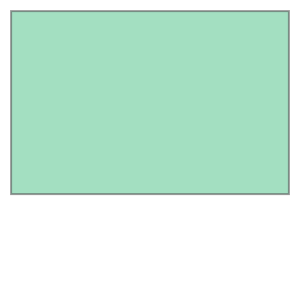

In [7]:
# Longitude/latitude extend of AOI (Lathu, north of Hog Harbour / Lonnoc Beach)
lonmin = 167.116
lonmax = 167.141
latmin = -15.113
latmax = -15.097
bbox_lonlat = shapely.geometry.box(minx=lonmin, miny=latmin, maxx=lonmax, maxy=latmax)

# Reproject from lon/lat to EPSG:3832
proj_func = pyproj.Transformer.from_crs(
    crs_from="OGC:CRS84", crs_to="EPSG:3832", always_xy=True
).transform
bbox_3832 = shapely.ops.transform(func=proj_func, geom=bbox_lonlat)
bbox_3832

In [8]:
xmin, ymin, xmax, ymax = bbox_3832.bounds

gdf_shorelines_crop = gdf_shorelines.clip(mask=bbox_3832)
gdf_ratesofchange_crop = gdf_ratesofchange.clip(mask=bbox_3832)

<Axes: >

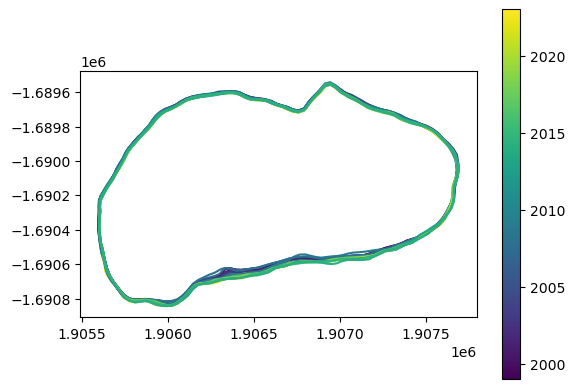

In [9]:
gdf_shorelines_crop.plot(column="year", cmap="viridis", legend=True)

<Axes: >

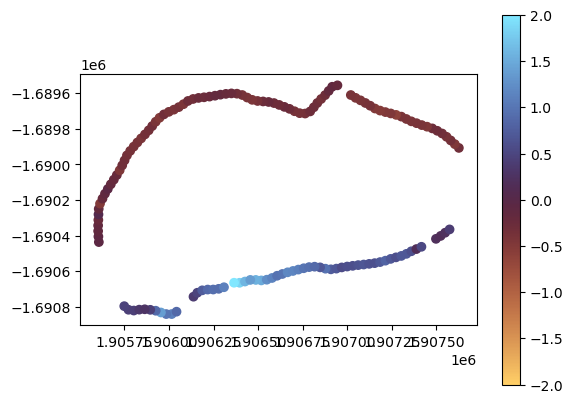

In [10]:
gdf_ratesofchange_crop.plot(
    column="rate_time", cmap="managua", vmin=-2, vmax=2, legend=True
)

Here, we can see that the Northern shoreline of the island is retreating, whereas the
Southern part of the island is expanding.

## Export for whole country

Let's now save the Vanuatu coastlines data to a geopackage (GPKG) file, which can hold
both the `shorelines_annual` and `rates_of_change` layers, plus QGIS styles.

In [ ]:
# Save annual shorelines
gdf_shorelines.to_file(
    filename="dep_ls_coastlines_vut_0-7-0-55.gpkg",
    layer="shorelines_annual",
    driver="GPKG",
    mode="w",
)

In [ ]:
# Save rates of change
gdf_ratesofchange.to_file(
    filename="dep_ls_coastlines_vut_0-7-0-55.gpkg",
    layer="rates_of_change",
    driver="GPKG",
)

In [ ]:
# Save QGIS styles
gdf_styles = gpd.read_file(
    # filename="dep_ls_coastlines_0-7-0-55.gpkg",
    filename=byte_stream,
    layer="layer_styles",
)
gdf_styles.to_file(
    filename="dep_ls_coastlines_vut_0-7-0-55.gpkg",
    layer="layer_styles",
    driver="GPKG",
)